In [1]:
# Importing standard python libraries
%matplotlib inline
import numpy as np
from math import pi,sqrt
import matplotlib.pyplot as plt

In [2]:
# Importing standard Qiskit libraries

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import transpile

from qiskit.quantum_info import Statevector

from qiskit.visualization import plot_distribution, plot_bloch_multivector
from qiskit.visualization import array_to_latex

from qiskit_aer import AerSimulator

In [13]:
InputQ = QuantumRegister(1, name='InputQ')
Medida = ClassicalRegister(1, name='Medida')

# Start with an one qubit quantum circuit yielding a nice fractal. Change the circuit as you like.
circuit = QuantumCircuit(InputQ,Medida)
circuit.h(0)
circuit.u(pi/4, -pi/3, pi/8, 0)

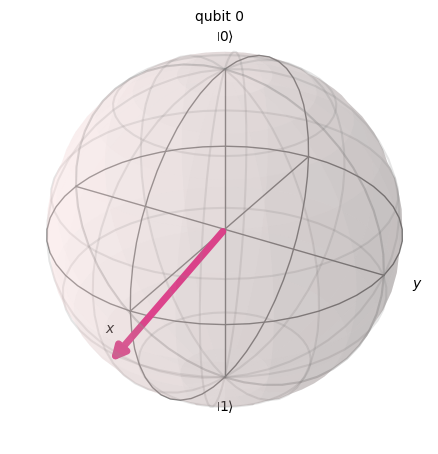

In [11]:
# Ver el estado cuántico del circuito en la esfera de Bloch
out_qubit  = circuit

plot_bloch_multivector(out_qubit)
plt.show()

In [12]:
# Definición de simuladores requeridos
statevector_simulator = AerSimulator(method='statevector')
# circuit_simulator = AerSimulator()

In [13]:
# Copia del circuito para obtener el vector de estado final resultante
circuit2SV = circuit.copy()
circuit2SV.save_statevector()

In [14]:
# Transpilación para posteriormente realizar la simulación del vector de estado resultante
circ_statevector = transpile(circuit2SV, statevector_simulator)

# Run the circuit with the state vector simulator to obtain a noise-free fractal.
# Ejecución y obtención del statevector
result = statevector_simulator.run(circ_statevector).result()
out_statevector = result.get_statevector(circ_statevector)

display(array_to_latex(Statevector(out_statevector), prefix="\\ket{out_{statevector}} = "))

<IPython.core.display.Latex object>

In [15]:
# Probabilidades asociadas el vector de estado resultante
print(out_statevector.probabilities())

[0.17335926 0.82664074]


In [16]:
# Extraiga el primer elemento del vector de estado como z0 y el segundo elemento como z1.
z0 = out_statevector.data[0]
z1 = out_statevector.data[1]

print(z0, z1)

(0.4032814824381882-0.10355339059327401j) (0.6535820712792957-0.6320373543718439j)


In [17]:
#Objetivo: Un número complejo para el fractal del conjunto de Julia.
if z1.real != 0 or z1.imag != 0:
    z = z0/z1
    print("Pre z= ",z)
    z = round(z.real, 2) + round(z.imag, 2) * 1j
else:
     z = 0 

print("z= ",z)

# Define the size
size = 1000
heightsize = size
widthsize = size

Pre z=  (0.3980292057007836+0.2264687818789998j)
z=  (0.4+0.23j)


In [18]:
def julia_set(c=z, height=heightsize, width=widthsize, x=0, y=0, zoom=1, max_iterations=100):

    # To make navigation easier we calculate these values
    x_width = 1.5
    y_height = 1.5*height/width
    x_from = x - x_width/zoom
    x_to = x + x_width/zoom
    y_from = y - y_height/zoom
    y_to = y + y_height/zoom
    
    # Here the actual algorithm starts and the z paramter is defined for the Julia set function
    x = np.linspace(x_from, x_to, width).reshape((1, width))
    y = np.linspace(y_from, y_to, height).reshape((height, 1))
    z = x + 1j * y
    
    # Initialize c to the complex number obtained from the quantum circuit
    c = np.full(z.shape, c)
    
    # To keep track in which iteration the point diverged
    div_time = np.zeros(z.shape, dtype=int)
    
    # To keep track on which points did not converge so far
    m = np.full(c.shape, True, dtype=bool)
    
    for i in range(max_iterations):
        z[m] = z[m]**2 + c[m] 
        m[np.abs(z) > 2] = False
        div_time[m] = i
    return div_time

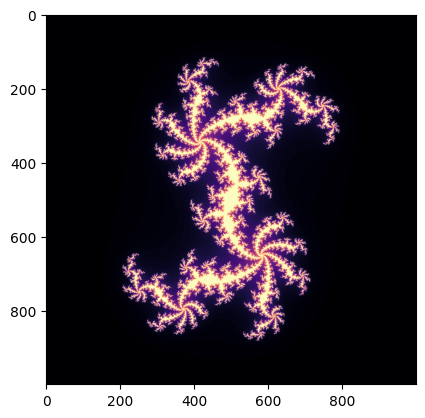

In [19]:
# plot the Julia set fractal
plt.imshow(julia_set(), cmap='magma') # viridis', 'plasma', 'inferno', 'magma', 'cividis'
plt.show()

In [15]:
from qiskit_ibm_runtime import SamplerV2 as Sampler, QiskitRuntimeService
from qiskit.transpiler import generate_preset_pass_manager

In [21]:
from qiskit_ibm_runtime import SamplerV2 as Sampler, QiskitRuntimeService
# from qiskit.transpiler import generate_preset_pass_manager

# The fake provider module contains fake providers and fake backends classes. 
# The fake backends are built to mimic the behaviors of IBM Quantum systems using system snapshots. 
# This allows to simulate a noise model generated from system snapshots obtained in the past.
# Here we choose a noise model based on an old backend named ibmq_Bogota of 5 qubits.
from qiskit_ibm_runtime.fake_provider import FakeBogotaV2

In [ ]:
# Loading your IBM Quantum account(s)
token="8d92a8f9d33cd2afd6f5796fb9d426f42ddeb0196587be6819b3e5c2262315b82f8a43c90076d939f45d92a2fa06dcd93b8b296f195837d301c1e09bb35f1cd9"
service=QiskitRuntimeService(channel="ibm_quantum",token=token)
ibmq_backend = FakeBogotaV2()

# print("The least busy quantum computer now is:", ibmq_backend.name)
print("Now the chosen quantum computer is:", ibmq_backend.name)

Now the chosen quantum computer is: fake_bogota


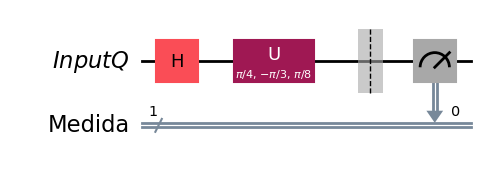

In [32]:
# Add measurement - used to calculate the modified state vector
circuit.barrier()
circuit.measure(InputQ, Medida)

circuit.draw('mpl', style="iqp")
plt.show()

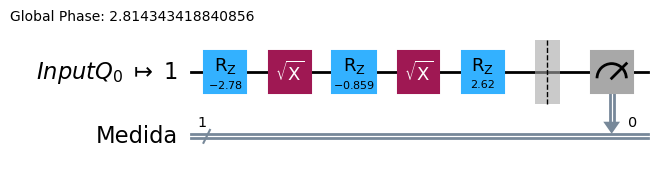

In [33]:
# Transpile the ideal circuit to a circuit that can be
# directly executed by the backend
transpiled_circuit = transpile(circuit, ibmq_backend)

transpiled_circuit.draw('mpl', style="iqp")
plt.show()

In [34]:
sampler2run = Sampler(mode=ibmq_backend)

# Define the number of shots for the execution. 
shotno=1024

# Run the circuit on a real quantum computer. NB! This may take a while.
job = sampler2run.run([transpiled_circuit], shots= shotno)

# ID del Job para rastrear la ejecución del circuito en tiempo real.
print(f">>> Job ID: {job.job_id()}")

# Consulta del estado de la ejecución del circuito cuántico
print(f">>> Job Status: {job.status()}")

>>> Job ID: f164fd43-28f9-43ab-92c1-1d64a3431309
>>> Job Status: JobStatus.RUNNING


In [35]:
# Nueva verificación del estado de la ejecución del circuito cuántico
print(f">>> Job Status: {job.status()}")

>>> Job Status: JobStatus.DONE


In [36]:
result = job.result()

# Get results for the first (and only) PUB
pub_result = result[0]

# Get count measurement results
counts = pub_result.data.Medida.get_counts()

print(
    f"Counts for the 'meas' output register: {counts}"
)

Counts for the 'meas' output register: {'1': 803, '0': 221}


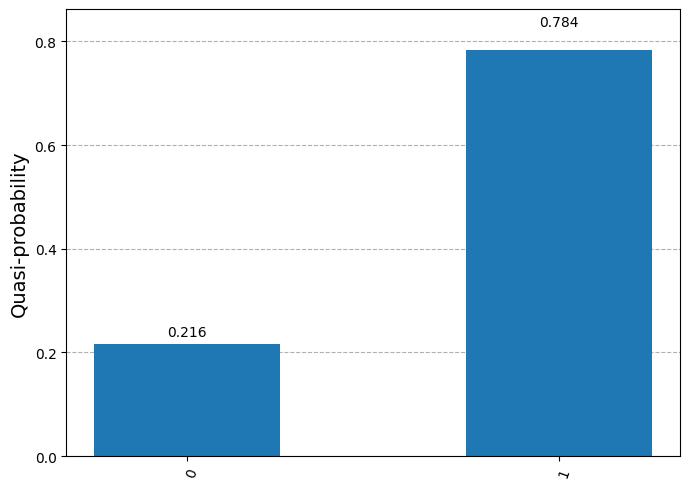

In [37]:
# Probabilidades de medición de cada salida, dada la ejecución real realizada.
plot_distribution(counts)

plt.show()

In [38]:
prob0qc = counts['0']/shotno
prob1qc = counts['1']/shotno
#print("Observed probabilities of measuring the computational basis states", round(prob0qc,3), round(prob1qc,3))

#print("Statevector: ", out)
#print("Statevector probilities of measuring the basis states: ", out.probabilities())
prob0statevec = out_statevector.probabilities()[0]
prob1statevec = out_statevector.probabilities()[1]

# one simple approach to calculate a quantum computer-modified complex number # amplitude^2 = probability
z0qc = z0*sqrt(prob0qc/prob0statevec)
z1qc = z1*sqrt(prob1qc/prob1statevec)
zqc = z0qc/z1qc
#zqcminus = -z0qc/z1qc
#print(z,zqc,zqcminus)

# compare the simulator state vector with the-running-on-a-real-quantum-computer modified state vector
print(z,zqc)

(0.4+0.23j) (0.45597201226291734+0.2594368069204625j)


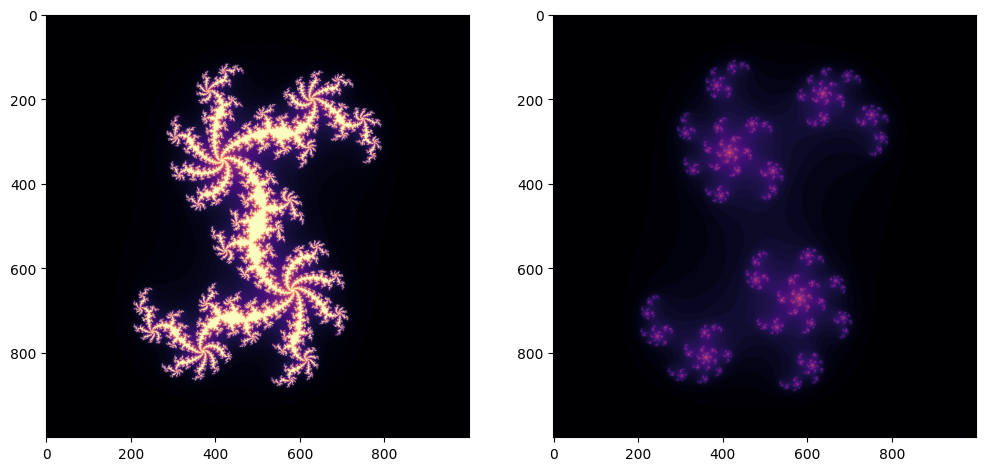

In [39]:
# Plot both Julia set fractals for comparison - the simulator based on the left and the modified on the right 
f, axarr = plt.subplots(1,2,figsize=(12, 12))
axarr[0].imshow(julia_set(c=z), cmap='magma')
axarr[1].imshow(julia_set(c=zqc), cmap='magma')

In [40]:
from qiskit import __version__
print(__version__)

2.0.0


***3.4.1. evolución unitaria en múltiples iteraciones***

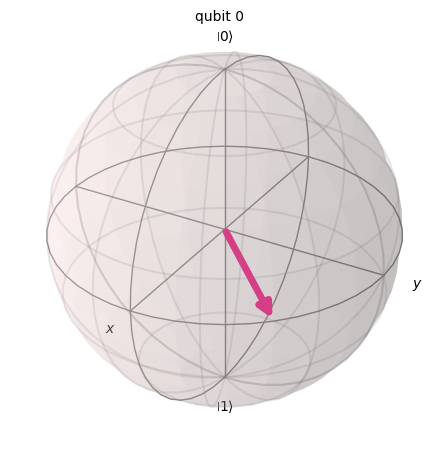

In [ ]:
InputQ = QuantumRegister(1, name='InputQ')
Medida = ClassicalRegister(1, name='Medida')

circuit = QuantumCircuit(InputQ,Medida)
circuit.h(0)
circuit.t(0) #rotacion de fase pi/4 
#circuit.y(0)



#circuit.u(pi/4, -pi/3, pi/8, 0)

# Ver el estado cuántico del circuito en la esfera de Bloch
out_qubit  = circuit

plot_bloch_multivector(out_qubit)
plt.show()

In [80]:
# Definición de simuladores requeridos
statevector_simulator = AerSimulator(method='statevector')

# Copia del circuito para obtener el vector de estado final resultante
circuit2SV = circuit.copy()
circuit2SV.save_statevector()

# Transpilación para posteriormente realizar la simulación del vector de estado resultante
circ_statevector = transpile(circuit2SV, statevector_simulator)

# Run the circuit with the state vector simulator to obtain a noise-free fractal.
# Ejecución y obtención del statevector
result = statevector_simulator.run(circ_statevector).result()
out_statevector = result.get_statevector(circ_statevector)

display(array_to_latex(Statevector(out_statevector), prefix="\\ket{out_{statevector}} = "))

# Probabilidades asociadas el vector de estado resultante
print(out_statevector.probabilities())

<IPython.core.display.Latex object>

[0.5 0.5]


In [3]:
def julia_set(c, height=300, width=300, x=0, y=0, zoom=1, max_iterations=300):
    x_width = 1.5
    y_height = 1.5 * height / width
    x_from = x - x_width / zoom
    x_to = x + x_width / zoom
    y_from = y - y_height / zoom
    y_to = y + y_height / zoom

    x_vals = np.linspace(x_from, x_to, width).reshape((1, width))
    y_vals = np.linspace(y_from, y_to, height).reshape((height, 1))
    z = x_vals + 1j * y_vals
    c_array = np.full(z.shape, c)

    div_time = np.zeros(z.shape, dtype=int)
    mask = np.full(z.shape, True, dtype=bool)

    for i in range(max_iterations):
        z[mask] = z[mask]**2 + c_array[mask]
        mask[np.abs(z) > 2] = False
        div_time[mask] = i

    return div_time


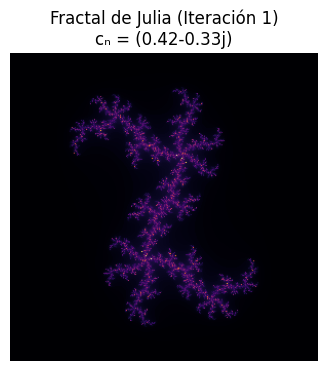

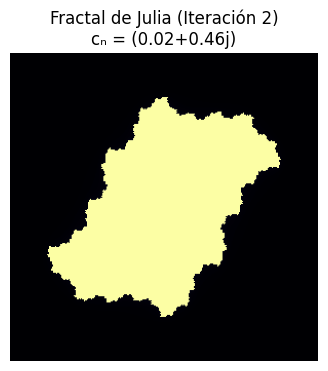

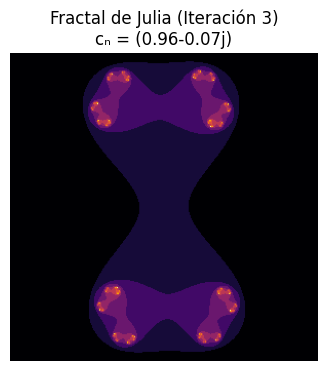

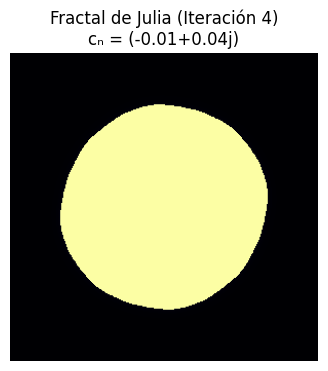

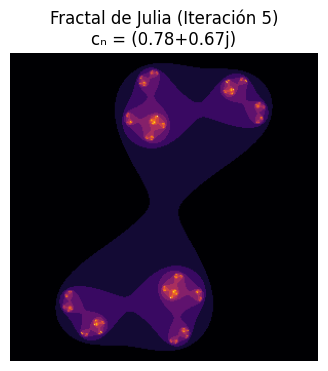

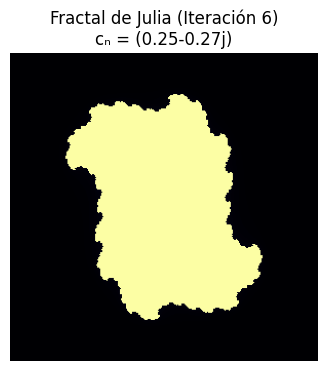

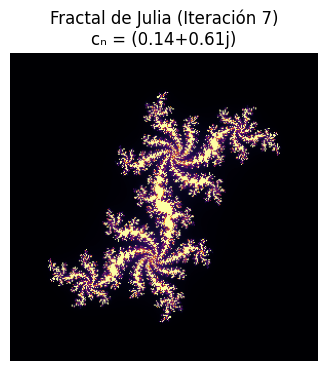

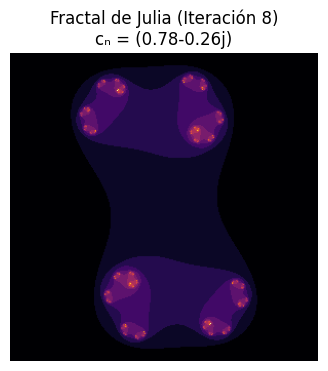

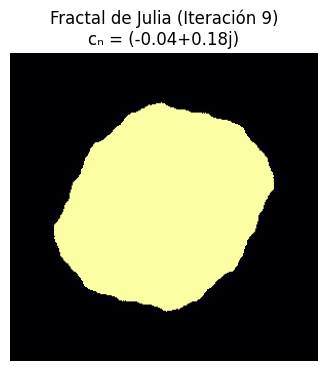

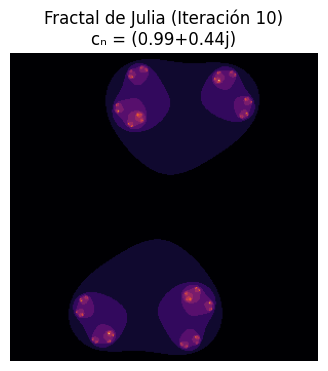

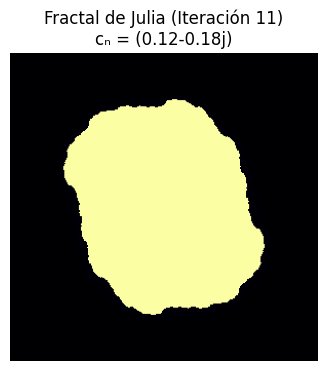

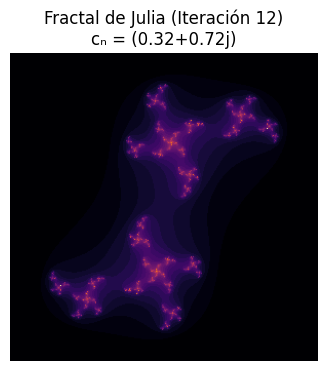

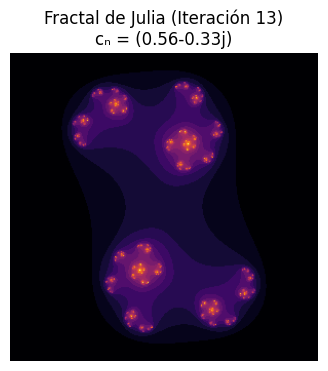

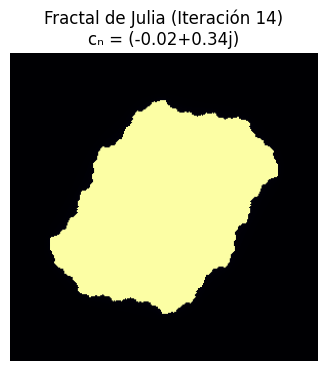

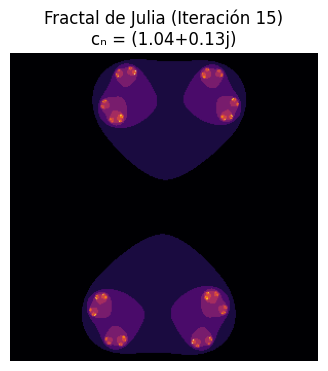

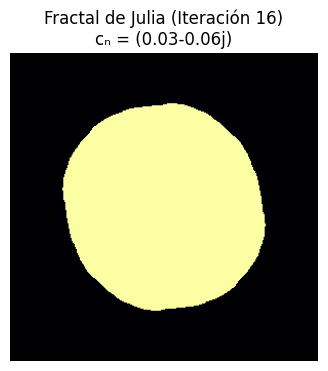

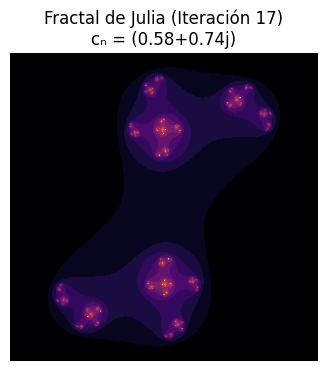

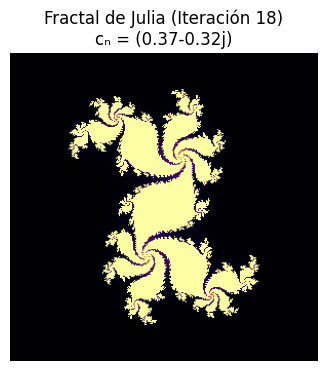

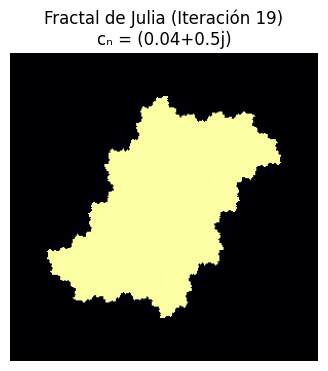

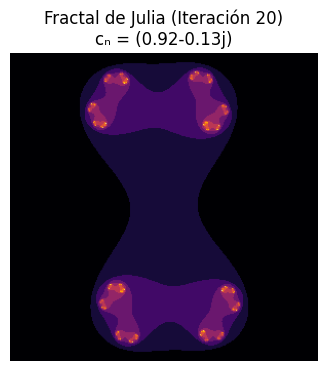

In [82]:
#  cₙ = β/α
c_n_values = []
n_iter = 20


out_statevector = out_statevector.evolve(circuit)
alpha = out_statevector.data[0]
beta = out_statevector.data[1]

if alpha != 0:
    c_n = beta / alpha
    c_n = round(c_n.real, 2) + round(c_n.imag, 2) * 1j
else:
    c_n = 0


for i in range(n_iter):
    #  simular evolución unitaria ideal (sin ruido).
    out_statevector = out_statevector.evolve(circuit)  # Evolución unitaria 
    #print(out_statevector)
    
    alpha = out_statevector.data[0]
    beta = out_statevector.data[1]

    if alpha != 0:
        c_n = beta / alpha
        c_n = round(c_n.real, 2) + round(c_n.imag, 2) * 1j
    else:
        c_n = 0

    c_n_values.append(c_n)

    # Mostrar el fractal para este valor de c
    plt.figure(figsize=(4, 4))
    plt.imshow(julia_set(c_n), cmap='inferno')
    plt.title(f"Fractal de Julia (Iteración {i+1})\ncₙ = {c_n}")
    plt.axis('off')
    plt.show()


In [85]:
from qiskit_ibm_runtime import SamplerV2 as Sampler, QiskitRuntimeService
from qiskit.transpiler import generate_preset_pass_manager

from qiskit_ibm_runtime import SamplerV2 as Sampler, QiskitRuntimeService
# from qiskit.transpiler import generate_preset_pass_manager

# The fake provider module contains fake providers and fake backends classes. 
# The fake backends are built to mimic the behaviors of IBM Quantum systems using system snapshots. 
# This allows to simulate a noise model generated from system snapshots obtained in the past.
# Here we choose a noise model based on an old backend named ibmq_Bogota of 5 qubits.
from qiskit_ibm_runtime.fake_provider import FakeBogotaV2

In [86]:
# Loading your IBM Quantum account(s)
token="8d92a8f9d33cd2afd6f5796fb9d426f42ddeb0196587be6819b3e5c2262315b82f8a43c90076d939f45d92a2fa06dcd93b8b296f195837d301c1e09bb35f1cd9"
service=QiskitRuntimeService(channel="ibm_quantum",token=token)
ibmq_backend = FakeBogotaV2()

# print("The least busy quantum computer now is:", ibmq_backend.name)
print("Now the chosen quantum computer is:", ibmq_backend.name)

Now the chosen quantum computer is: fake_bogota


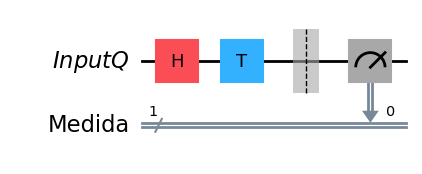

In [87]:
# Add measurement - used to calculate the modified state vector
circuit.barrier()
circuit.measure(InputQ, Medida)

circuit.draw('mpl', style="iqp")
plt.show()

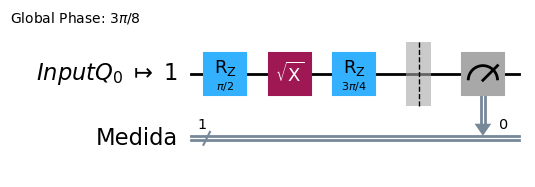

In [88]:
# Transpile the ideal circuit to a circuit that can be
# directly executed by the backend
transpiled_circuit = transpile(circuit, ibmq_backend)

transpiled_circuit.draw('mpl', style="iqp")
plt.show()

In [93]:
sampler2run = Sampler(mode=ibmq_backend)

# Define the number of shots for the execution. 
shotno=1024

# Run the circuit on a real quantum computer. NB! This may take a while.
job = sampler2run.run([transpiled_circuit], shots= shotno)

# ID del Job para rastrear la ejecución del circuito en tiempo real.
print(f">>> Job ID: {job.job_id()}")

# Consulta del estado de la ejecución del circuito cuántico
print(f">>> Job Status: {job.status()}")

>>> Job ID: 3c8ac241-afe8-40c6-8346-a76f767dceba
>>> Job Status: JobStatus.RUNNING


In [50]:
# Nueva verificación del estado de la ejecución del circuito cuántico
print(f">>> Job Status: {job.status()}")

>>> Job Status: JobStatus.DONE


In [52]:
result = job.result()

# Get results for the first (and only) PUB
pub_result = result[0]

# Get count measurement results
counts = pub_result.data.Medida.get_counts()

print(
    f"Counts for the 'meas' output register: {counts}"
)

Counts for the 'meas' output register: {'1': 551, '0': 473}


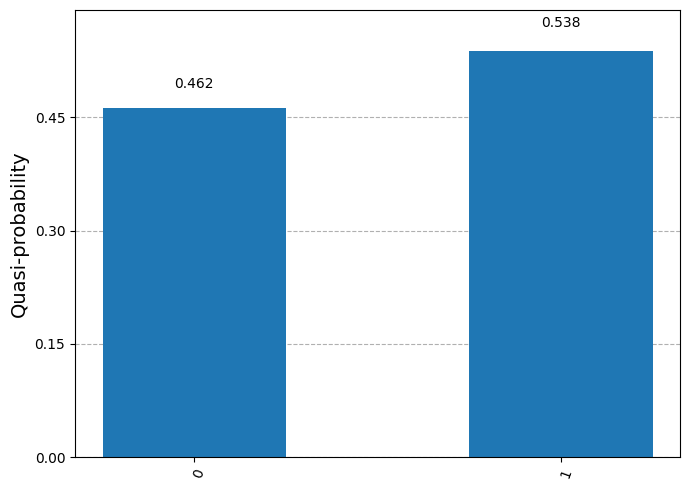

In [53]:
# Probabilidades de medición de cada salida, dada la ejecución real realizada.
plot_distribution(counts)

plt.show()

In [63]:
prob0qc = counts['0']/shotno
prob1qc = counts['1']/shotno
#print("Observed probabilities of measuring the computational basis states", round(prob0qc,3), round(prob1qc,3))

#print("Statevector: ", out)
#print("Statevector probilities of measuring the basis states: ", out.probabilities())
prob0statevec = out_statevector.probabilities()[0]
prob1statevec = out_statevector.probabilities()[1]

# one simple approach to calculate a quantum computer-modified complex number # amplitude^2 = probability
z0qc = alpha*sqrt(prob0qc/prob0statevec)
z1qc = beta*sqrt(prob1qc/prob1statevec)
zqc = z0qc/z1qc
#zqcminus = -z0qc/z1qc
#print(z,zqc,zqcminus)

# compare the simulator state vector with the-running-on-a-real-quantum-computer modified state vector
print(c_n_values[0],zqc)

(-0.57+0.1j) (0.6440838868597761+0.6660293898466558j)


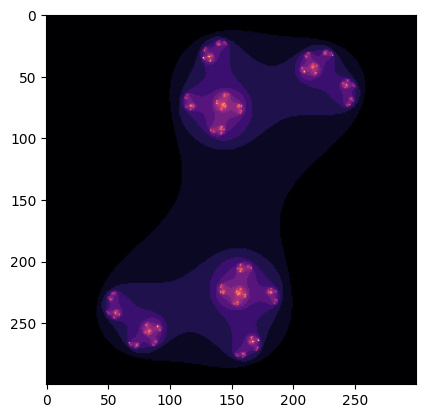

In [65]:
plt.imshow(julia_set(zqc), cmap='magma') # viridis', 'plasma', 'inferno', 'magma', 'cividis'
plt.show()

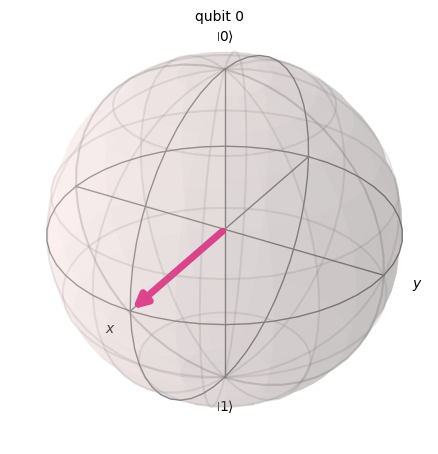

<IPython.core.display.Latex object>

[0.5 0.5]


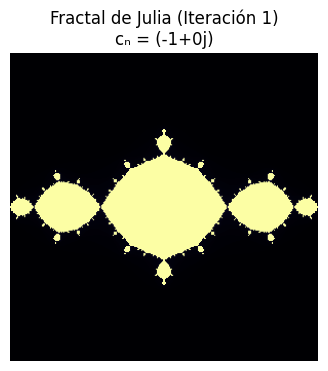

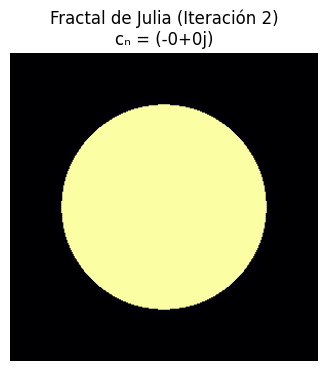

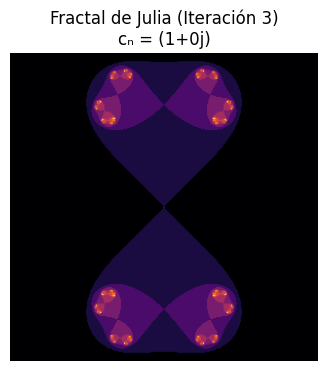

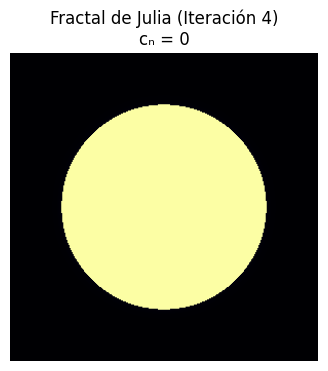

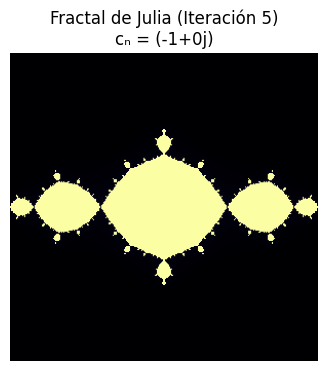

In [7]:
InputQ = QuantumRegister(1, name='InputQ')
Medida = ClassicalRegister(1, name='Medida')

circuit = QuantumCircuit(InputQ,Medida)
circuit.h(0)
circuit.x(0)
#circuit.y(0)



#circuit.u(pi/4, -pi/3, pi/8, 0)

# Ver el estado cuántico del circuito en la esfera de Bloch
out_qubit  = circuit

plot_bloch_multivector(out_qubit)
plt.show()

# Definición de simuladores requeridos
statevector_simulator = AerSimulator(method='statevector')

# Copia del circuito para obtener el vector de estado final resultante
circuit2SV = circuit.copy()
circuit2SV.save_statevector()

# Transpilación para posteriormente realizar la simulación del vector de estado resultante
circ_statevector = transpile(circuit2SV, statevector_simulator)

# Run the circuit with the state vector simulator to obtain a noise-free fractal.
# Ejecución y obtención del statevector
result = statevector_simulator.run(circ_statevector).result()
out_statevector = result.get_statevector(circ_statevector)

display(array_to_latex(Statevector(out_statevector), prefix="\\ket{out_{statevector}} = "))

# Probabilidades asociadas el vector de estado resultante
print(out_statevector.probabilities())

#  cₙ = β/α
c_n_values = []
n_iter = 5


out_statevector = out_statevector.evolve(circuit)
alpha = out_statevector.data[0]
beta = out_statevector.data[1]

if alpha != 0:
    c_n = beta / alpha
    c_n = round(c_n.real, 2) + round(c_n.imag, 2) * 1j
else:
    c_n = 0


for i in range(n_iter):
    #  simular evolución unitaria ideal (sin ruido).
    out_statevector = out_statevector.evolve(circuit)  # Evolución unitaria 
    #print(out_statevector)
    
    alpha = out_statevector.data[0]
    beta = out_statevector.data[1]

    if alpha != 0:
        c_n = beta / alpha
        c_n = round(c_n.real, 2) + round(c_n.imag, 2) * 1j
    else:
        c_n = 0

    c_n_values.append(c_n)

    # Mostrar el fractal para este valor de c
    plt.figure(figsize=(4, 4))
    plt.imshow(julia_set(c_n), cmap='inferno')
    plt.title(f"Fractal de Julia (Iteración {i+1})\ncₙ = {c_n}")
    plt.axis('off')
    plt.show()


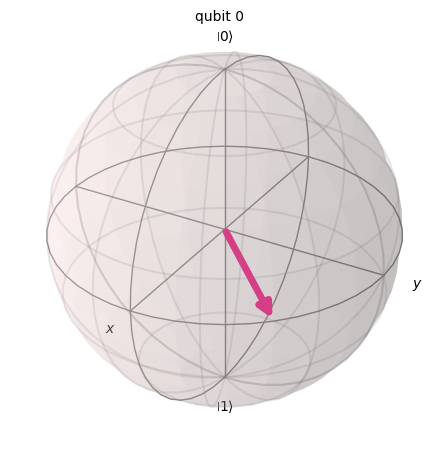

<IPython.core.display.Latex object>

[0.5 0.5]


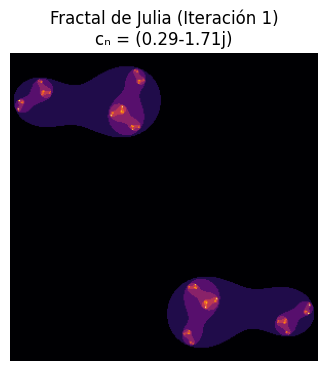

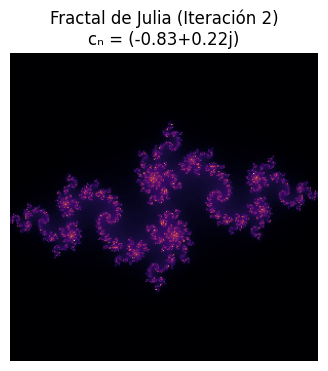

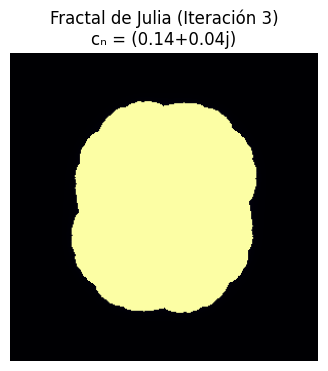

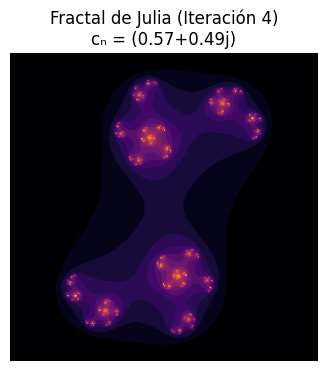

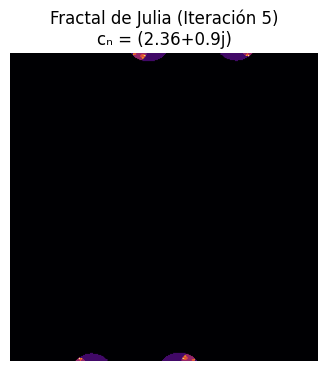

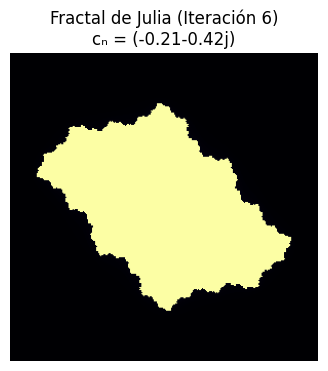

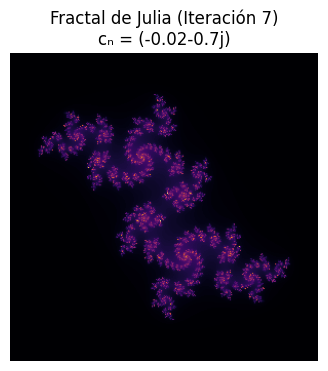

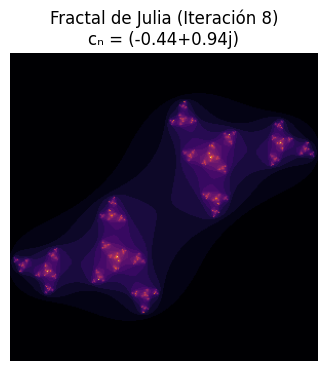

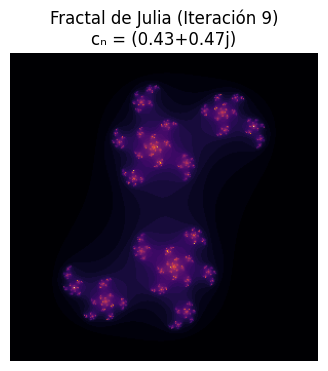

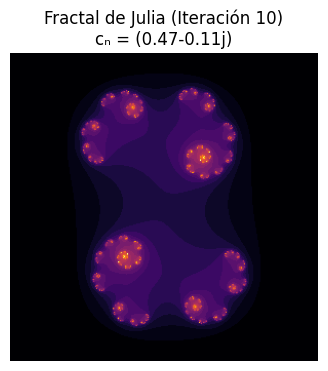

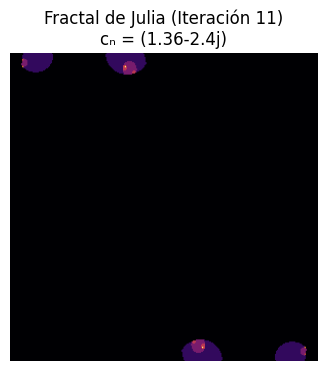

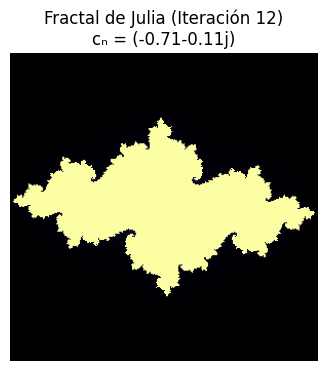

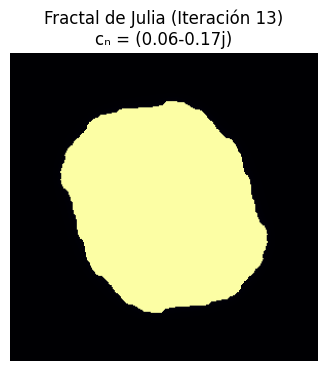

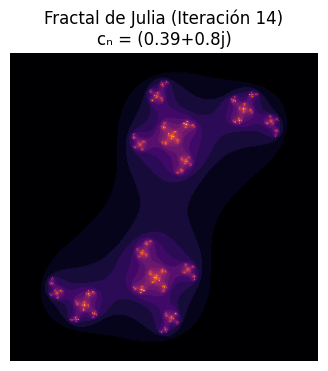

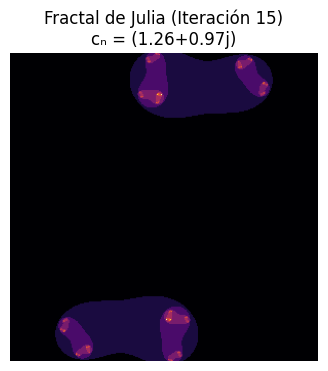

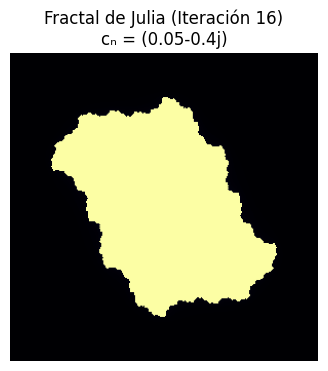

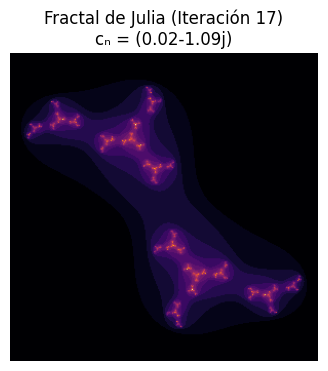

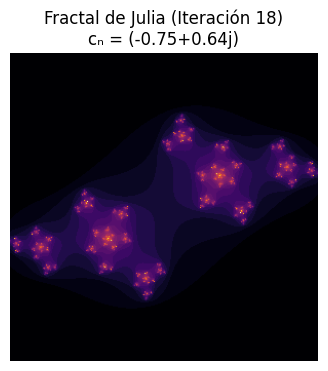

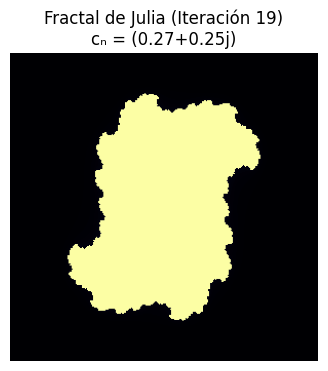

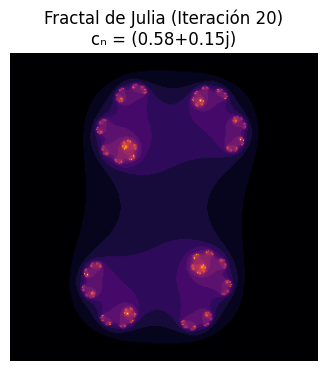

In [19]:
InputQ = QuantumRegister(1, name='InputQ')
Medida = ClassicalRegister(1, name='Medida')

circuit = QuantumCircuit(InputQ,Medida)
circuit.h(0)
circuit.t(0)
#circuit.y(0)



#circuit.u(pi/4, -pi/3, pi/8, 0)

# Ver el estado cuántico del circuito en la esfera de Bloch
out_qubit  = circuit

plot_bloch_multivector(out_qubit)
plt.show()

# Definición de simuladores requeridos
statevector_simulator = AerSimulator(method='statevector')

# Copia del circuito para obtener el vector de estado final resultante
circuit2SV = circuit.copy()
circuit2SV.save_statevector()

# Transpilación para posteriormente realizar la simulación del vector de estado resultante
circ_statevector = transpile(circuit2SV, statevector_simulator)

# Run the circuit with the state vector simulator to obtain a noise-free fractal.
# Ejecución y obtención del statevector
result = statevector_simulator.run(circ_statevector).result()
out_statevector = result.get_statevector(circ_statevector)

display(array_to_latex(Statevector(out_statevector), prefix="\\ket{out_{statevector}} = "))

# Probabilidades asociadas el vector de estado resultante
print(out_statevector.probabilities())

#  cₙ = β/α
c_n_values = []
n_iter = 20


out_statevector = out_statevector.evolve(circuit)
alpha = out_statevector.data[0]
beta = out_statevector.data[1]

if alpha != 0:
    c_n = beta / alpha
    c_n = round(c_n.real, 2) + round(c_n.imag, 2) * 1j
else:
    c_n = 0


for i in range(n_iter):
    #  simular evolución unitaria ideal (sin ruido).
    circuit.x(0)
    out_statevector = out_statevector.evolve(circuit)  # Evolución unitaria 
    #print(out_statevector)
    
    alpha = out_statevector.data[0]
    beta = out_statevector.data[1]

    if alpha != 0:
        c_n = beta / alpha
        c_n = round(c_n.real, 2) + round(c_n.imag, 2) * 1j
    else:
        c_n = 0

    c_n_values.append(c_n)

    # Mostrar el fractal para este valor de c
    plt.figure(figsize=(4, 4))
    plt.imshow(julia_set(c_n), cmap='inferno') #viridis', 'plasma', 'inferno', 'magma', 'cividis'
    plt.title(f"Fractal de Julia (Iteración {i+1})\ncₙ = {c_n}")
    plt.axis('off')
    plt.show()
